In [1]:
# Clone the repository
!git clone https://github.com/ApoPeri/tensorgator.git
# Navigate to the directory
%cd tensorgator
# Install with the desired package name
!pip install -e . --install-option="--name=tensorgator"

Cloning into 'tensorgator'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 35 (delta 2), reused 35 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 350.63 KiB | 10.63 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/tensorgator

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --install-option


In [ ]:
#Change runtime (top left) by ram/disk to T4

Detected GPU memory: 15.00 GB
Testing with 1000 satellites...
  Testing with 100 timesteps...
  Using batch sizes: 1000 satellites, 100 timesteps
    Run 1/5...
    Completed in 0.01 seconds
    Run 2/5...
    Completed in 0.01 seconds
    Run 3/5...
    Completed in 0.01 seconds
    Run 4/5...
    Completed in 0.01 seconds
    Run 5/5...
    Completed in 0.01 seconds
  Average: 0.01 seconds (±0.00)
  Testing with 250 timesteps...
  Using batch sizes: 1000 satellites, 250 timesteps
    Run 1/5...
    Completed in 0.02 seconds
    Run 2/5...
    Completed in 0.02 seconds
    Run 3/5...
    Completed in 0.02 seconds
    Run 4/5...
    Completed in 0.02 seconds
    Run 5/5...
    Completed in 0.02 seconds
  Average: 0.02 seconds (±0.00)
  Testing with 500 timesteps...
  Using batch sizes: 1000 satellites, 500 timesteps
    Run 1/5...
    Completed in 0.03 seconds
    Run 2/5...
    Completed in 0.03 seconds
    Run 3/5...
    Completed in 0.03 seconds
    Run 4/5...
    Completed in 0.03 

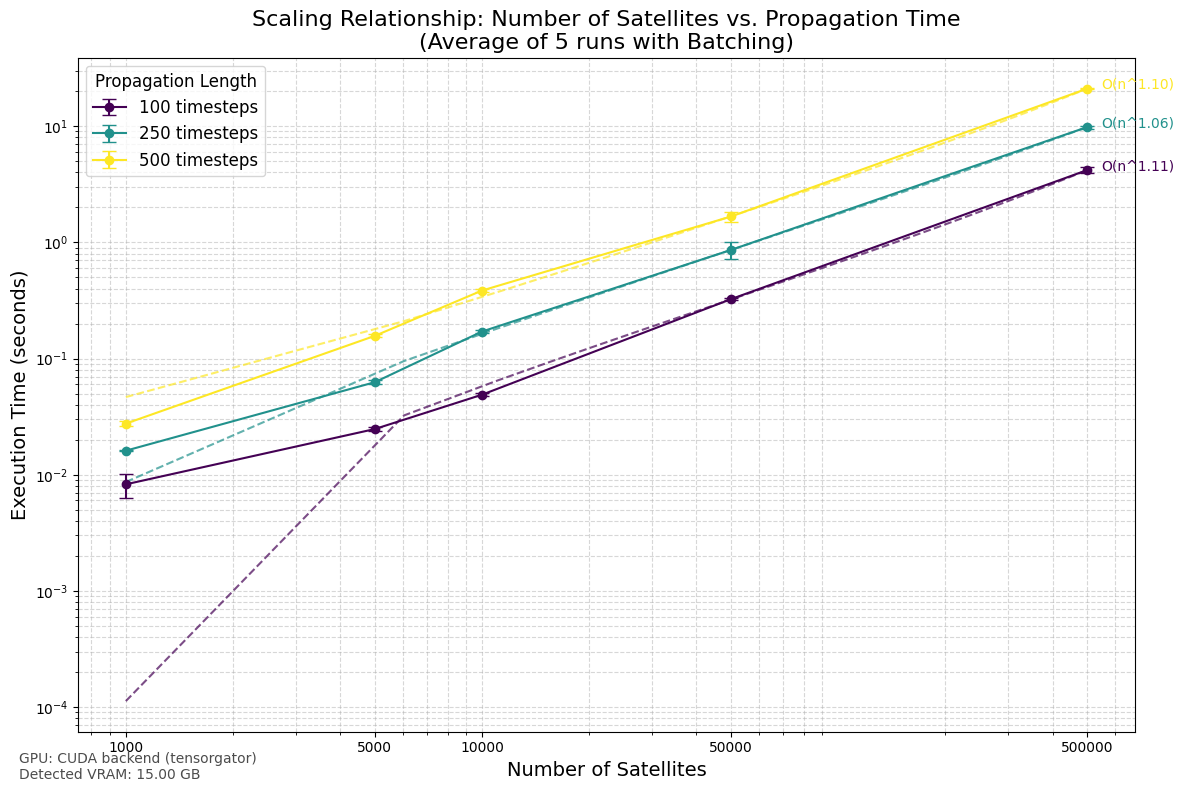


Scaling Analysis:
For 100 timesteps: Time complexity approximately O(n^1.11)
For 250 timesteps: Time complexity approximately O(n^1.06)
For 500 timesteps: Time complexity approximately O(n^1.10)

Batch Sizes Used:
Config: 1000 satellites, 100 timesteps
  Batch sizes: 1000 satellites, 100 timesteps
  Total batches: 1 (1 × 1)
Config: 1000 satellites, 250 timesteps
  Batch sizes: 1000 satellites, 250 timesteps
  Total batches: 1 (1 × 1)
Config: 1000 satellites, 500 timesteps
  Batch sizes: 1000 satellites, 500 timesteps
  Total batches: 1 (1 × 1)
Config: 5000 satellites, 100 timesteps
  Batch sizes: 5000 satellites, 100 timesteps
  Total batches: 1 (1 × 1)
Config: 5000 satellites, 250 timesteps
  Batch sizes: 5000 satellites, 250 timesteps
  Total batches: 1 (1 × 1)
Config: 5000 satellites, 500 timesteps
  Batch sizes: 5000 satellites, 500 timesteps
  Total batches: 1 (1 × 1)
Config: 10000 satellites, 100 timesteps
  Batch sizes: 10000 satellites, 100 timesteps
  Total batches: 1 (1 × 1)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys
import subprocess
import re

import tensorgator as tg
from tensorgator.prop_cuda import propagate_constellation_cuda
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

def detect_gpu_memory():
    try:
        result = subprocess.check_output(['nvidia-smi', '--query-gpu=memory.total', '--format=csv,noheader,nounits'],
                                        universal_newlines=True)
        memory_values = [int(x) for x in result.strip().split('\n')]
        return memory_values[0] * 1024 * 1024  # Convert MB to bytes
    except (subprocess.SubprocessError, FileNotFoundError):
        try:
            import torch
            if torch.cuda.is_available():
                return torch.cuda.get_device_properties(0).total_memory
            else:
                return 4 * 1024 * 1024 * 1024  # Default 4GB if can't detect
        except ImportError:
            return 4 * 1024 * 1024 * 1024  # Default 4GB if can't detect

def batch_propagate(constellation, times, batch_size_sats=None, batch_size_times=None, return_frame='ecef'):
    num_sats = len(constellation)
    num_times = len(times)

    if batch_size_sats is None:
        batch_size_sats = num_sats
    if batch_size_times is None:
        batch_size_times = num_times

    positions = np.zeros((num_sats, num_times, 3), dtype=np.float32)

    for sat_start in range(0, num_sats, batch_size_sats):
        sat_end = min(sat_start + batch_size_sats, num_sats)
        sat_batch = constellation[sat_start:sat_end]

        for time_start in range(0, num_times, batch_size_times):
            time_end = min(time_start + batch_size_times, num_times)
            time_batch = times[time_start:time_end]

            batch_positions = propagate_constellation_cuda(
                sat_batch, time_batch, return_frame=return_frame)

            positions[sat_start:sat_end, time_start:time_end, :] = batch_positions

    return positions

def estimate_optimal_batch_size(max_sats, max_times):
    bytes_per_sat_time = 20
    available_memory = detect_gpu_memory() * 0.7  # Use 70% of detected VRAM

    total_memory = max_sats * max_times * bytes_per_sat_time

    if total_memory <= available_memory:
        return max_sats, max_times

    memory_ratio = available_memory / total_memory

    batch_size_sats = int(np.sqrt(memory_ratio * max_sats * max_times))

    if batch_size_sats > max_sats / 2:
        batch_size_sats = max_sats
        batch_size_times = int(available_memory / (batch_size_sats * bytes_per_sat_time))
    else:
        batch_size_times = int(available_memory / (batch_size_sats * bytes_per_sat_time))

    batch_size_sats = max(100, min(batch_size_sats, max_sats))
    batch_size_times = max(100, min(batch_size_times, max_times))

    return batch_size_sats, batch_size_times

def benchmark_propagation(satellite_counts, timestep_counts, num_runs=5):
    results = {
        'satellite_counts': satellite_counts,
        'timestep_counts': timestep_counts,
        'execution_times': np.zeros((len(satellite_counts), len(timestep_counts))),
        'std_devs': np.zeros((len(satellite_counts), len(timestep_counts))),
        'batch_sizes': [],
    }

    RE = tg.RE
    np.random.seed(42)

    for i, num_sats in enumerate(satellite_counts):
        print(f"Testing with {num_sats} satellites...")

        constellation = []
        alt_range = (300000, 2000000)
        inc_range = (20, 98)

        for _ in range(num_sats):
            altitude = np.random.uniform(*alt_range)
            a = RE + altitude
            e = 0.0
            inc = np.radians(np.random.uniform(*inc_range))
            raan = np.radians(np.random.uniform(0, 360))
            argp = np.radians(np.random.uniform(0, 360))
            M0 = np.radians(np.random.uniform(0, 360))

            constellation.append([a, e, inc, raan, argp, M0])

        constellation = np.array(constellation)

        for j, num_timesteps in enumerate(timestep_counts):
            print(f"  Testing with {num_timesteps} timesteps...")

            time_step = 5
            times = np.arange(0, num_timesteps * time_step, time_step)

            batch_size_sats, batch_size_times = estimate_optimal_batch_size(num_sats, num_timesteps)
            results['batch_sizes'].append((num_sats, num_timesteps, batch_size_sats, batch_size_times))

            print(f"  Using batch sizes: {batch_size_sats} satellites, {batch_size_times} timesteps")

            run_times = []
            for run in range(num_runs):
                print(f"    Run {run+1}/{num_runs}...")

                if run==0:
                    batch_propagate(constellation, times,
                               batch_size_sats=batch_size_sats,
                               batch_size_times=batch_size_times)
                start_time = time.time()

                batch_propagate(constellation, times,
                               batch_size_sats=batch_size_sats,
                               batch_size_times=batch_size_times)

                elapsed_time = time.time() - start_time
                run_times.append(elapsed_time)
                print(f"    Completed in {elapsed_time:.2f} seconds")

            avg_time = np.mean(run_times)
            std_dev = np.std(run_times)

            results['execution_times'][i, j] = avg_time
            results['std_devs'][i, j] = std_dev
            print(f"  Average: {avg_time:.2f} seconds (±{std_dev:.2f})")

    return results

def plot_results(results):
    satellite_counts = results['satellite_counts']
    timestep_counts = results['timestep_counts']
    execution_times = results['execution_times']
    std_devs = results['std_devs']
    batch_sizes = results['batch_sizes']

    plt.figure(figsize=(12, 8))

    colors = plt.cm.viridis(np.linspace(0, 1, len(timestep_counts)))

    for j, timestep in enumerate(timestep_counts):
        plt.errorbar(satellite_counts, execution_times[:, j],
                    yerr=std_devs[:, j],
                    marker='o', linestyle='-', color=colors[j],
                    label=f'{timestep} timesteps', capsize=5)

    plt.xlabel('Number of Satellites', fontsize=14)
    plt.ylabel('Execution Time (seconds)', fontsize=14)
    plt.title('Scaling Relationship: Number of Satellites vs. Propagation Time\n(Average of 5 runs with Batching)', fontsize=16)

    for j, timestep in enumerate(timestep_counts):
        z = np.polyfit(satellite_counts, execution_times[:, j], 2)
        p = np.poly1d(z)

        x_smooth = np.linspace(min(satellite_counts), max(satellite_counts), 100)
        plt.plot(x_smooth, p(x_smooth), '--', color=colors[j], alpha=0.7)

    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.legend(title="Propagation Length", fontsize=12, title_fontsize=12)

    plt.xscale('log')
    plt.yscale('log')

    plt.xticks(satellite_counts, [str(s) for s in satellite_counts])

    for j, timestep in enumerate(timestep_counts):
        if len(satellite_counts) >= 3:
            x1, x2 = satellite_counts[-2], satellite_counts[-1]
            y1, y2 = execution_times[-2, j], execution_times[-1, j]
            k = np.log(y2/y1) / np.log(x2/x1)

            plt.annotate(f'O(n^{k:.2f})',
                        xy=(satellite_counts[-1], execution_times[-1, j]),
                        xytext=(10, 0), textcoords='offset points',
                        color=colors[j], fontsize=10)

    available_memory = detect_gpu_memory() / (1024*1024*1024)  # Convert to GB
    info_text = f"GPU: CUDA backend (tensorgator)\nDetected VRAM: {available_memory:.2f} GB"
    plt.figtext(0.02, 0.02, info_text, fontsize=10, alpha=0.7)

    plt.tight_layout()
    plt.savefig('satellite_propagation_scaling_batched.png', dpi=300)

    plt.show()

    print("\nScaling Analysis:")
    print("=================")
    for j, timestep in enumerate(timestep_counts):
        if len(satellite_counts) >= 3:
            x1, x2 = satellite_counts[-2], satellite_counts[-1]
            y1, y2 = execution_times[-2, j], execution_times[-1, j]
            k = np.log(y2/y1) / np.log(x2/x1)
            print(f"For {timestep} timesteps: Time complexity approximately O(n^{k:.2f})")

    print("\nBatch Sizes Used:")
    print("=================")
    for num_sats, num_times, batch_sats, batch_times in batch_sizes:
        num_batches_sats = np.ceil(num_sats / batch_sats)
        num_batches_times = np.ceil(num_times / batch_times)
        total_batches = num_batches_sats * num_batches_times
        print(f"Config: {num_sats} satellites, {num_times} timesteps")
        print(f"  Batch sizes: {batch_sats} satellites, {batch_times} timesteps")
        print(f"  Total batches: {total_batches:.0f} ({num_batches_sats:.0f} × {num_batches_times:.0f})")

def main():
    available_memory_gb = detect_gpu_memory() / (1024*1024*1024)
    print(f"Detected GPU memory: {available_memory_gb:.2f} GB")

    satellite_counts = [1000, 5000, 10000, 50000, int(5e5)]
    timestep_counts = [100, 250, 500]

    results = benchmark_propagation(satellite_counts, timestep_counts, num_runs=5)
    plot_results(results)

if __name__ == "__main__":
    main()